# Project: TMDB-movies

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
### Dataset Description 
This data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.

I will be investigating the TMDB Movies dataset to tackle the cinema industry and find insights and correlations between profit, popularity and IMDB rating along with the: Genres, Cast and directors.
### Question(s) for Analysis
>**Q1**: Whih actors participate in the highest profit movies ?

> **Q2**: Which directors participate in the highest profitable movies and with what genres ?

> **Q3** Does the vote rating and audience popularity has a direct relation ? And how is this relation presented in profit ?

### *Data column Description* : 
#### below is the Data set Columns Description. I highlighted the <mark>*interesting*</mark> characteristics according to my point of view.


|Column Number||Column name||Description|
|:-------------||:-----------||:-----------|
|0||id||ID for the movie in the dataset |
|1||imdb_id||The Imdb ID|
|2||<mark>**popularity**</mark>||Assuming popularity of movies in percentage values|
|3||budget||The budget value with respect to nowadays|
|4||revenue||The Revenue value with respect to nowadays|
|5||<mark>**original_title**</mark>||The original movie title |
|6||<mark>**cast**</mark>||Cast|
|7||homepage||Movie's website |
|8||<mark>**director**</mark>||Director|
|9||tagline||Tag line under the movie|
|10||<mark>**keywords**</mark>||Key words rekeveant to movie's vibes and Genre|
|11||overview||Or headline or Intro|
|12||runtime||Length of the movie in minutes|
|13||<mark>**genres**</mark>||genre/genres of the movie|
|14||<mark>**production_companies**</mark>||Production company/Production companies|
|15||release_date||The release date|
|16||<mark>**vote_count**</mark>||Number of votes|
|17||<mark>**vote_average**</mark>||Average voting|
|18||release_year||Release year|
|19||<mark>**budget_adj**</mark>||The budget value with respect to 2010 US dollars|
|20||<mark>**revenue_adj**</mark>||The budget value with respect to 2010 US dollars|

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# matplotlib inline
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In [76]:
df = pd.read_csv('tmdb-movies.csv')
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


In [80]:
df.popularity.describe()

count    10866.000000
mean         0.646441
std          1.000185
min          0.000065
25%          0.207583
50%          0.383856
75%          0.713817
max         32.985763
Name: popularity, dtype: float64

In [ ]:
df.shape

In [ ]:
df.describe()

In [ ]:
df.shape


### Data Cleaning 
> **1**: I will drop the Budget and Revenue columns because it's more significant to use the adjusted 2010  US$ values.

In [ ]:
df.drop(columns=['budget', 'revenue'], inplace=True)
df.head(1)

> **2**: Checking NAN values

In [ ]:
df.isna().sum().sort_values(ascending=False)

<br>1- As shown above, the charectristic with the highest **nan** values is the homepage. which is important but not mandatory in my analysis. Instead of just deleting its equivalent row values I will just replace them with **"None"**.
<br>2- I will also do the same for **tagline** and **production companies**.
<br>3- I will delete the union of the **nan** values in the following rows ==> **cast, director, genres, imdb_id** and **overview**
<br>4- I will replace the nan values found in **keywords** with those found in their respective **genre**, as genres and keywords are a little bit alike.

In [ ]:
df.homepage.fillna('None', inplace=True)
df.tagline.fillna('None', inplace=True)
df.production_companies.fillna('None', inplace=True)

In [ ]:
df.dropna(subset=['cast', 'director', 'genres', 'imdb_id', 'overview'], how='any', inplace=True)

In [ ]:
df.keywords.fillna(df.genres, inplace=True)
df.isna().sum().any()

In [ ]:
df.shape

In [ ]:
df.duplicated().sum()

In [ ]:
df.drop_duplicates(inplace=True)
df.shape

> **3**: Checking Dtypes

In [ ]:
df.info()

I will convert the following dtypes: release_date ==> date time

In [ ]:
df.release_date = pd.to_datetime(df.release_date)
df.release_date.dtype

> **4**: Add the profit Column

In [ ]:
df['profit'] = df['revenue_adj'] - df['budget_adj']

> **5**: Reset the index to avoid any indexing errors or mis interpretation 

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.drop(columns=['index'], inplace=True)
df.head(1)

> **6**: Deal with any pipe separated values in all the columns

In [ ]:
pipe_separated_columns = []
for column in df.columns:
    if df[column].dtype == object:
        for i, value in enumerate(df[column]):
            if "|" in value:
                if column not in pipe_separated_columns:
                    pipe_separated_columns.append(column)
pipe_separated_columns

##### We are only interested in cast, director and genres

In [ ]:
# This Cell Takes long time and saving the dataframes to csv does not save the dtype of lists. There for I will use it
# sequencally in the Data wrangling process.
cast_errors = []
director_errors = []
genres_errors = []
for column in pipe_separated_columns:
    if column in ['cast', 'director', 'genres']:
        print(column)
        for i in range(len(df[column])):
            try:
                df[column][i] = df[column].str.split('|')[i] # ==> No need for the index i here ?
                #df[column] = df[column].str.split('|')
                #print("i ==> {}\ncolumn name ==> {}\nColumn first element type ==> {}\nColumn first element value ==> {}".format(i, column, type(df[column][0]), df[column][0]))
            except:
                if column == 'cast':
                    cast_errors.append(i)
                if column == 'director':
                    director_errors.append(i)
                if column == 'genres':
                    genres_errors.append(i)

In [ ]:
dict_errors = {'cast_errors':cast_errors, 'director_errors':director_errors, 'genres_errors': genres_errors}
df_pipe_errors = pd.DataFrame(dict_errors)

In [ ]:
df_pipe_errors.to_csv("pipe_separated_row_errors.csv")

In [ ]:
unique_cast = []
unique_directors = []
unique_genres = []
variables = ['cast', 'genres', 'director']
for column in variables:
    for i in range(len(df[column])):
        if i not in cast_errors:
            try:
                if column == 'cast':
                    for actor in df[column][i]:
                        if actor not in unique_cast:
                            unique_cast.append(actor)
                elif column == 'genres':
                    for genre in df[column][i]:
                        if genre not in unique_genres:
                            unique_genres.append(genre)
                else:
                    for director in df[column][i]:
                        if director not in unique_directors:
                            unique_directors.append(director)
            except:
                print(i, column)

In [ ]:
cast_dict = {key:0 for key in unique_cast}
director_dict = {key:0 for key in unique_directors}
genre_dict = {key:0 for key in unique_genres}

variables = ['cast', 'genres', 'director']
for column in variables:
    for i in range(len(df[column])):
        if i not in cast_errors:
            try:
                if column == 'cast':
                    for actor in df[column][i]:
                        cast_dict[actor] += 1
                elif column == 'genres':
                    for genre in df[column][i]:
                        genre_dict[genre] += 1
                else:
                    for director in df[column][i]:
                        director_dict[director] += 1
            except:
                print(i, column)

In [ ]:
with open('cast.txt', 'w', encoding='utf-8') as file:
    for key, value in cast_dict.items():
        file.write(key + ' : ' + str(value) + '\n')

In [ ]:
with open('genre.txt', 'w', encoding='utf-8') as file:
    for key, value in genre_dict.items():
        file.write(key + ' : ' + str(value) + '\n')

In [ ]:
with open('director.txt', 'w', encoding='utf-8') as file:
    for key, value in director_dict.items():
        file.write(key + ' : ' + str(value) + '\n')

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1 (Which Genres are most popular from time to time ?)

In [6]:
df_genre = pd.read_csv('df_main_clean.csv', index_col=[0])

In [7]:
df_genre.head(1)

,popularity,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
0,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09


In [8]:
bin_edges = [int(df_genre.release_year.describe()[3]), int(df_genre.release_year.describe()[4]), int(df_genre.release_year.describe()[5]), int(df_genre.release_year.describe()[6]), int(df_genre.release_year.describe()[7])]
bin_labels = [ '1960-1994', '1994-2005', '2005-2011', '2011-2015']
df_genre['year_bins'] = pd.cut(x=df_genre.release_year, bins=bin_edges, labels=bin_labels)

In [9]:
df_genre[['release_year', 'year_bins']].head()

,release_year,year_bins
0,2015,2011-2015
1,2015,2011-2015
2,2015,2011-2015
3,2015,2011-2015
4,2015,2011-2015


In [10]:
df_genre.head(1)

,popularity,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,year_bins
0,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09,2011-2015


In [11]:
genres_errors = []
for i in range(len(df_genre.genres)):
    try:
        df_genre['genres'][i] = df_genre['genres'].str.split('|')[i] # ==> No need for the index i here ?
        #df_genre[;genres] = df_genre[;genres].str.split('|')
        #print("i ==> {}\n;genres name ==> {}\n;genres first element type ==> {}\n;genres first element value ==> {}".format(i, ;genres, type(df_genre[;genres][0]), df_genre[;genres][0]))
    except:
            genres_errors.append(i)

C:\Users\MANUEL~1\AppData\Local\Temp/ipykernel_10620/2044205383.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre['genres'][i] = df_genre['genres'].str.split('|')[i] # ==> No need for the index i here ?


In [12]:
df_genre.dropna()

,popularity,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,year_bins
0,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,"[Action, Adventure, Science Fiction, Thriller]",Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09,2011-2015
1,28.419936,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,future|chase|post-apocalyptic|dystopia|australia,120,"[Action, Adventure, Science Fiction, Thriller]",Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08,2.101614e+08,2011-2015
2,13.112507,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,based on novel|revolution|dystopia|sequel|dyst...,119,"[Adventure, Science Fiction, Thriller]",Summit Entertainment|Mandeville Films|Red Wago...,2015-03-18,2480,6.3,2015,1.012000e+08,2.716190e+08,1.704191e+08,2011-2015
3,11.173104,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,android|spaceship|jedi|space opera|3d,136,"[Action, Adventure, Science Fiction, Fantasy]",Lucasfilm|Truenorth Productions|Bad Robot,2015-12-15,5292,7.5,2015,1.839999e+08,1.902723e+09,1.718723e+09,2011-2015
4,9.335014,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,car race|speed|revenge|suspense|car,137,"[Action, Crime, Thriller]",Universal Pictures|Original Film|Media Rights ...,2015-04-01,2947,7.3,2015,1.747999e+08,1.385749e+09,1.210949e+09,2011-2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10719,0.080598,The Endless Summer,Michael Hynson|Robert August|Lord 'Tally Ho' B...,Bruce Brown,surfer|surfboard|surfing,95,[Documentary],Bruce Brown Films,2066-06-15,11,7.4,1966,0.000000e+00,0.000000e+00,0.000000e+00,1960-1994
10720,0.065543,Grand Prix,James Garner|Eva Marie Saint|Yves Montand|Tosh...,John Frankenheimer,car race|racing|formula 1,176,"[Action, Adventure, Drama]",Cherokee Productions|Joel Productions|Douglas ...,2066-12-21,20,5.7,1966,0.000000e+00,0.000000e+00,0.000000e+00,1960-1994
10721,0.065141,Beregis Avtomobilya,Innokentiy Smoktunovskiy|Oleg Efremov|Georgi Z...,Eldar Ryazanov,car|trolley|stealing car,94,"[Mystery, Comedy]",Mosfilm,2066-01-01,11,6.5,1966,0.000000e+00,0.000000e+00,0.000000e+00,1960-1994
10722,0.064317,"What's Up, Tiger Lily?",Tatsuya Mihashi|Akiko Wakabayashi|Mie Hama|Joh...,Woody Allen,spoof,80,"[Action, Comedy]",Benedict Pictures Corp.,2066-11-02,22,5.4,1966,0.000000e+00,0.000000e+00,0.000000e+00,1960-1994


In [13]:
#saving our data frame in case anything happens
df_genre_original = df_genre.copy()

In [14]:
df_genre = df_genre.explode(column='genres')
df_genre.dropna(inplace=True)

In [54]:
df_genre.to_csv('df_genre.csv')

In [15]:
#Scanning out genres
df_genre.columns

Index(['popularity', 'original_title', 'cast', 'director', 'keywords',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj', 'profit', 'year_bins'],
      dtype='object')

#### Main functions to be used

In [50]:
def getheights(df):
    heights = []
    for genre in df.genres.unique():
        x_genre = df.query('genres == "{}"'.format(genre))
        heights.append(x_genre.popularity.mean())

    for i, number in enumerate(heights):
        heights[i] = int(round(number, 2) * 100)
        
    return heights

In [51]:
def getbars(df):
    bars = df.genres.unique()
    return bars

In [52]:
def plotbar(plottilte, bars, heights):
    y_pos = np.arange(len(bars))

    # Create bars
    plt.bar(y_pos, heights)

    # Create names on the x-axis
    plt.xticks(y_pos, bars, rotation=90)

    # Add title and axis names
    plt.title(plottilte)
    plt.xlabel('Genres')
    plt.ylabel('Popularity')

    # Show graphic
    plt.show()

### The most popular genres from 1960-1994

In [43]:
df_genre_1 = df_genre.query('year_bins == "1960-1994"')

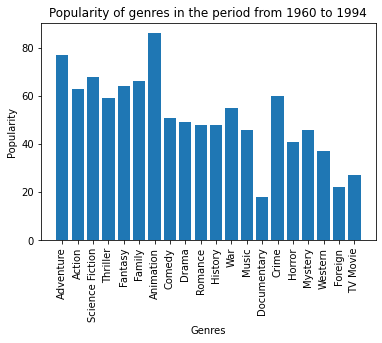

In [53]:
plotbar('Popularity of genres in the period from 1960 to 1994', getbars(df_genre_1), getheights(df_genre_1))

As seen the Animation genre was the most popular which I find as very interesting info here that might explain the reason why the anime is very popular these days. Seems like it's not something new anyways.

### The most popular genres from 1994 to 2005

In [55]:
df_genre_2 = df_genre.query('year_bins == "1994-2005"')

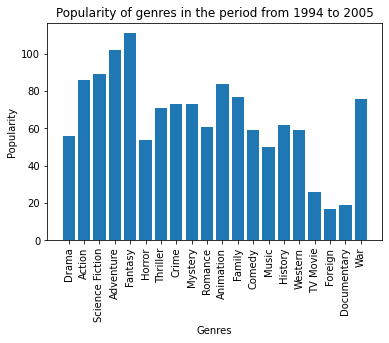

In [56]:
plotbar('Popularity of genres in the period from 1994 to 2005', getbars(df_genre_2), getheights(df_genre_2))

Fantasy took over here in the next era. Seems imagination was the key back then.

### The most popular genres from 2005 to 2011

In [57]:
df_genre_3 = df_genre.query('year_bins == "2005-2011"')

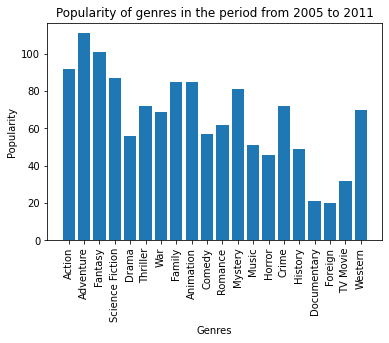

In [58]:
plotbar('Popularity of genres in the period from 2005 to 2011', getbars(df_genre_3), getheights(df_genre_3))

we here see some kind other types become to be more popular but Adventure is the highest.

### The most popular genres from 2011 to 2015

In [59]:
df_genre_4 = df_genre.query('year_bins == "2011-2015"')

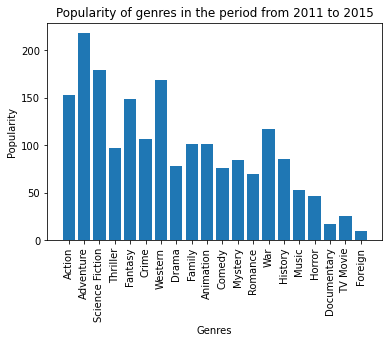

In [60]:
plotbar('Popularity of genres in the period from 2011 to 2015', getbars(df_genre_4), getheights(df_genre_4))

As we can see the Adventure is the highest and consistant till 2015

### The most popular genres for all times

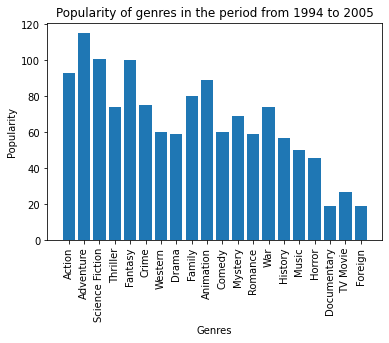

In [61]:
plotbar('Popularity of genres in the period from 1994 to 2005', getbars(df_genre), getheights(df_genre))

It's normal now to find that adventure is the most popular of all time

### Top Recorded Genres of all time:

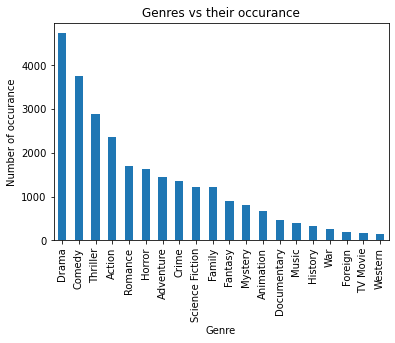

In [63]:
df_genre.genres.value_counts().plot(kind='bar', xlabel="Genre", ylabel="Number of occurance", title='Genres vs their occurance');

Despite the fact that adventure is the most popular genre, yet it's not the most occured on our database, however, Drama is.

### Percentage of recorded year bins

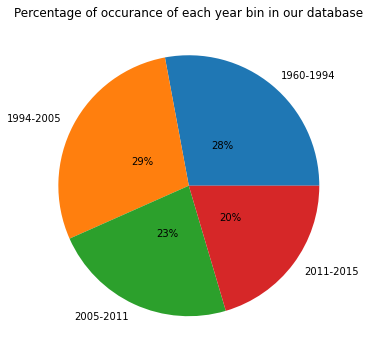

In [65]:
df_genre.groupby('year_bins')['genres'].count().plot(kind='pie', autopct='%1.0f%%', pctdistance=0.4, labeldistance=1.1,figsize=(6.5,6), ylabel="", title='Percentage of occurance of each year bin in our database');

the biggest data is for the time from 1994 to 2005

### Research Question 2  (Characteristics of highest profitable movies)

In [82]:
df = pd.read_csv('df_main_clean.csv', index_col=[0])
df.head(1)

,popularity,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
0,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09


In [67]:
df.profit.describe()

count    1.072400e+04
mean     3.426328e+07
std      1.259792e+08
min     -4.139124e+08
25%      0.000000e+00
50%      0.000000e+00
75%      1.386692e+07
max      2.750137e+09
Name: profit, dtype: float64

In [68]:
df.profit.describe()[6]

13866919.369998574

lets divide the data with the profit delimeter of 13866919 

In [85]:
df_profitable_movies = df.query('profit > 13866919.369998574')
df_profitable_movies.describe()

,popularity,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
count,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2.681000e+03,2.681000e+03,2.681000e+03
mean,1.411325,110.854905,675.210742,6.294666,1998.876912,4.547544e+07,1.951372e+08,1.496617e+08
std,1.679126,23.096073,1000.150805,0.744095,12.509152,4.928683e+07,2.383068e+08,2.124452e+08
min,0.010335,26.000000,10.000000,3.100000,1960.000000,0.000000e+00,1.387205e+07,1.387205e+07
25%,0.549206,96.000000,106.000000,5.800000,1990.000000,9.947032e+06,5.876984e+07,3.615428e+07
50%,0.975473,107.000000,304.000000,6.300000,2002.000000,3.000000e+07,1.126200e+08,7.536672e+07
75%,1.651962,121.000000,786.000000,6.800000,2009.000000,6.545264e+07,2.324602e+08,1.678548e+08
max,32.985763,705.000000,9767.000000,8.300000,2015.000000,3.683713e+08,2.827124e+09,2.750137e+09


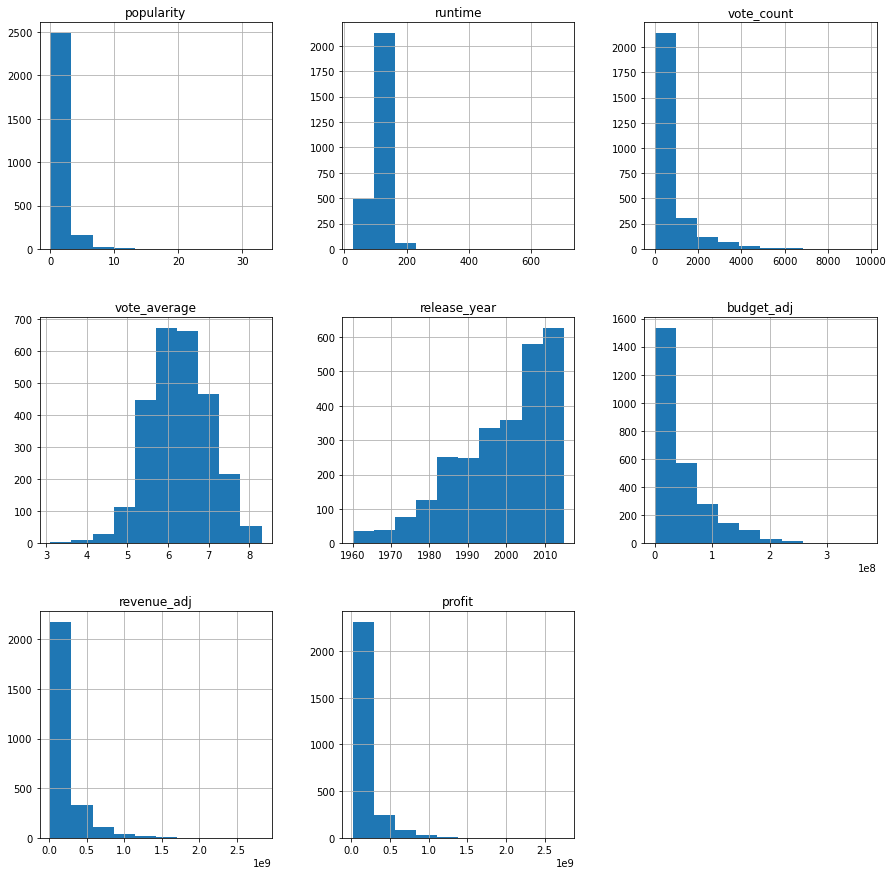

In [87]:
df_profitable_movies.hist(figsize=(15, 15));

In [110]:
df.query('profit > 13866919.369998574')['genres']

0        Action|Adventure|Science Fiction|Thriller
1        Action|Adventure|Science Fiction|Thriller
2               Adventure|Science Fiction|Thriller
3         Action|Adventure|Science Fiction|Fantasy
4                            Action|Crime|Thriller
                           ...                    
10677                                Action|Comedy
10680                                        Drama
10686                             Mystery|Thriller
10693           Action|Adventure|Drama|War|Romance
10706                    Adventure|Science Fiction
Name: genres, Length: 2681, dtype: object

### High profitable genres

In [95]:
df_genre_high_profitable = df_genre.query('profit > 13866919.369998574')

<AxesSubplot:title={'center':'MEan profits for each type of genre'}, xlabel='Genre', ylabel='Average profit'>

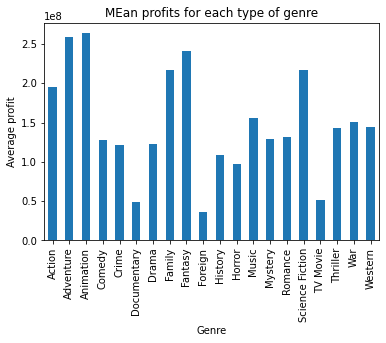

In [111]:
df_genre_high_profitable.groupby('genres')['profit'].mean().plot(kind='bar', xlabel='Genre', ylabel='Average profit', title='MEan profits for each type of genre')

The animation movies takes the first place as the highest profitable genre type movie.

<a id='conclusions'></a>
## Conclusions

</br> **1**: Although action and drama may be our first guess here for the most popular genres of all time, yet the Adventure holds the first place for the most popular genre of all time followed by Science fiction and fantasy.
</br> **2**: The characteristics of the most profitable movies is budget not less than 4.547544e+07, runtime no more than 2.7 hours, voting not less than 6 and genres to be either animation or adventure.

### Limitations

</br> **1**: The data only covers recorded periods from 1960 to 2015.
</br> **2**: There were no single instance for each genre by itself, instead I used the explode method to duplicate any row with all values but only different genre. This was because each movie could include more than one genre.


In [112]:
# from subprocess import call
# call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])